In [1]:
!pip install opencv-python


In [2]:
%load_ext autoreload
%autoreload 2
import img_text_composition_models
from enum import Enum
import datasets
import torchvision
import torch
from main import load_dataset, create_model_and_optimizer
import test_retrieval
from tqdm import tqdm
import cv2
from utils.FilePickling import pkl_save, pkl_load
import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
class opt_config:
    def __init__(self):
        self.dataset = "css3d"
        self.dataset_path = "../data/CSSDataset/CSS-vn-v2-segmenter.json" 
        self.model = "tirg_phobert" 
        self.loss = "soft_triplet" 
        self.comment = "tirg_phobert"
        self.embed_dim = 512
        self.learning_rate = 1e-2
        self.weight_decay = 1e-6 
        self.f = ""
        self.learning_rate_decay_frequency = 99999999
        self.batch_size = 32
        self.num_epochs = 100
        self.n_epochs_valudations = 5
        self.loader_num_workers = 4
        self.pretrained_weights = "runs/Dec12_14-57-59_ai-servers-1tirgphobert_css-vn-v2-segmenter/latest_checkpoint.pth"
        
opt = opt_config()

trainset, testset = load_dataset(opt)
texts = [t for t in trainset.get_all_texts()]
model = img_text_composition_models.TIRG(texts, embed_dim=opt.embed_dim)

Reading dataset  css3d
trainset size: 19012
testset size: 19057


In [5]:
trainset.generate_random_query_target()

{'source_img_id': 174,
 'source_img_data': tensor([[[-0.2856, -0.2856, -0.2856,  ..., -0.3541, -0.3541, -0.3712],
          [-0.2856, -0.2856, -0.2856,  ..., -0.3883, -0.3712, -0.3883],
          [-0.2856, -0.3027, -0.3027,  ..., -0.3883, -0.3883, -0.3883],
          ...,
          [ 0.0569,  0.0569,  0.0569,  ...,  0.2796,  0.2796,  0.2796],
          [ 0.0569,  0.0569,  0.0741,  ...,  0.2796,  0.2967,  0.2796],
          [ 0.0569,  0.0741,  0.0569,  ...,  0.2967,  0.2967,  0.2796]],
 
         [[-0.1625, -0.1625, -0.1625,  ..., -0.2500, -0.2325, -0.2500],
          [-0.1625, -0.1625, -0.1800,  ..., -0.2675, -0.2500, -0.2675],
          [-0.1800, -0.1800, -0.1800,  ..., -0.2675, -0.2675, -0.2675],
          ...,
          [ 0.1702,  0.1702,  0.1702,  ...,  0.3803,  0.3803,  0.3803],
          [ 0.1702,  0.1702,  0.1877,  ...,  0.3803,  0.3978,  0.3803],
          [ 0.1702,  0.1877,  0.1702,  ...,  0.3978,  0.3978,  0.3803]],
 
         [[ 0.0605,  0.0605,  0.0605,  ..., -0.0267, -0.00

In [4]:
model, optimizer = create_model_and_optimizer(opt, [t for t in trainset.get_all_texts()])

Creating model and optimizer for tirg
Pretrained model from runs/Sep23_05-38-54_ai-servers-3css_vn_vanilla_v2/latest_checkpoint.pth


# Get a random images

In [40]:
ab = trainset.generate_random_query_target()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


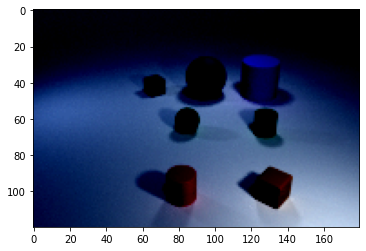

In [6]:
import matplotlib.pyplot as plt
plt.imshow(ab["source_img_data"].permute(1,2,0))

In [7]:
!pip install ipdb

# Read and load image from index

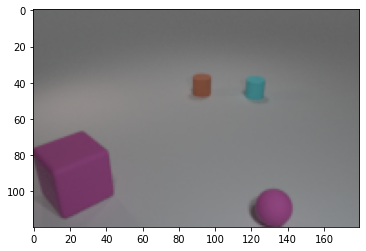

In [8]:
idx = 3
idx_fill = str(idx).zfill(6)
img = cv2.imread(f"../data/CSSDataset/images/css_test_{idx_fill}.png") 
plt.imshow(img)

# Compute test query features

In [11]:
test_queries = testset.get_test_queries()
train_queries = trainset.get_test_queries()

queries_dict = {"train": trainset, "test": testset}
chosen_set_str = "train" # test or train
chosen_set = queries_dict[chosen_set_str]
num_img_to_get = 3 
all_queries =[]

In [9]:

if test_queries:
    # compute test query features
    imgs = []
    mods = []
    for t in tqdm(test_queries):
        imgs += [testset.get_img(t["source_img_id"])]
        mods += [t["mod"]["str"]]
        if len(imgs) >= opt.batch_size or t is test_queries[-1]:
            if "torch" not in str(type(imgs[0])):
                imgs = [torch.from_numpy(d).float() for d in imgs]
            imgs = torch.stack(imgs).float()
            imgs = torch.autograd.Variable(imgs).cuda()
            mods = [t for t in mods]
            f = model.compose_img_text(imgs, mods).data.cpu().numpy()
            all_queries += [f]
            imgs = []
            mods = []
    all_queries = np.concatenate(all_queries)
    all_target_captions = [t["target_caption"] for t in test_queries]

100%|███████████████████████████████████████████████████████████████████████████| 18057/18057 [01:03<00:00, 283.81it/s]


In [14]:
img_ids = []
mods = []
for t in tqdm(test_queries):
    img_ids += [t["source_img_id"]]
    mods += [t["mod"]["str"]]

100%|███████████████████████████████████████████████████████████████████████| 18057/18057 [00:00<00:00, 1128661.12it/s]


In [15]:
pkl_save("pkl/img_ids.pkl",img_ids)
pkl_save("pkl/mods.pkl",mods)

In [35]:
pkl_save("pkl/all_queries.pkl", all_queries)
pkl_save("pkl/all_target_captions", all_target_captions)

 # Compute all image features

In [12]:
import numpy as np

In [17]:
all_imgs = []
all_captions = []

# compute all image features
imgs = []
all_imgs = []
for i in tqdm(list(range(len(testset.imgs)))):
    imgs += [testset.get_img(i)]
    if len(imgs) >= opt.batch_size or i == len(testset.imgs) - 1:
        if "torch" not in str(type(imgs[0])):
            imgs = [torch.from_numpy(d).float() for d in imgs]
        imgs = torch.stack(imgs).float()
        imgs = torch.autograd.Variable(imgs).cuda()
        imgs = model.extract_img_feature(imgs).data.cpu().numpy()
        all_imgs += [imgs]
        imgs = []
all_imgs = np.concatenate(all_imgs)
all_captions = [img["captions"][0] for img in testset.imgs]

100%|███████████████████████████████████████████████████████████████████████████| 19057/19057 [01:57<00:00, 162.76it/s]


In [5]:
all_queries = pkl_load("pkl/all_queries.pkl")
all_imgs = pkl_load("pkl/all_imgs.pkl")

# Evaluation

In [46]:
# feature normalization
for i in range(all_queries.shape[0]):
    all_queries[i, :] /= np.linalg.norm(all_queries[i, :])

for i in range(all_imgs.shape[0]):
    all_imgs[i, :] /= np.linalg.norm(all_imgs[i, :])
print("hello")
# match test queries to target images, get nearest neighbors
sims = all_queries.dot(all_imgs.T)

if test_queries:
    for i, t in enumerate(test_queries):
        sims[i, t["source_img_id"]] = -10e10  # remove query image

nn_result = [np.argsort(-sims[i, :])[:110] for i in range(sims.shape[0])]

hello


In [47]:
pkl_save("pkl/nn_result.pkl",nn_result)

In [50]:
len(nn_result)

18057

`nns` là kết quả trả về, `all_target_captions` là đáp số

In [64]:
len(all_target_captions)

18057

In [26]:
pkl_save("pkl/all_imgs.pkl",all_imgs)
pkl_save("pkl/all_captions.pkl", all_captions)

In [27]:
all_imgs = pkl_load("pkl/all_imgs.pkl")
all_captions = pkl_load("pkl/all_captions.pkl")
img_ids = pkl_load("pkl/img_ids.pkl")
mods = pkl_load("pkl/mods.pkl")
nn_result = pkl_load("pkl/nn_result.pkl")
all_target_captions = pkl_load("pkl/all_target_captions.pkl")

In [28]:
all_target_captions[true_idx]

'1372'

# Visualization 

Text(0.5, 1.0, 'thêm khối màu xám')

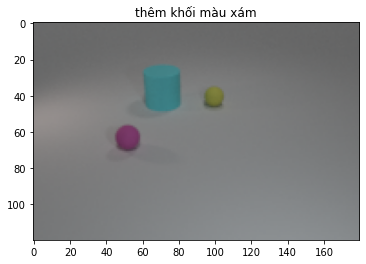

- imgs là tensor `[batch_size, 3,120,180]`
- texts là list str len `batch_size`

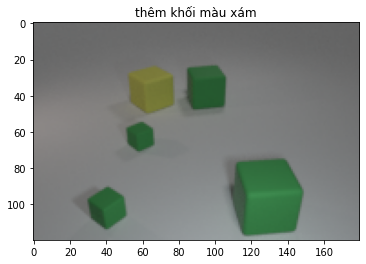

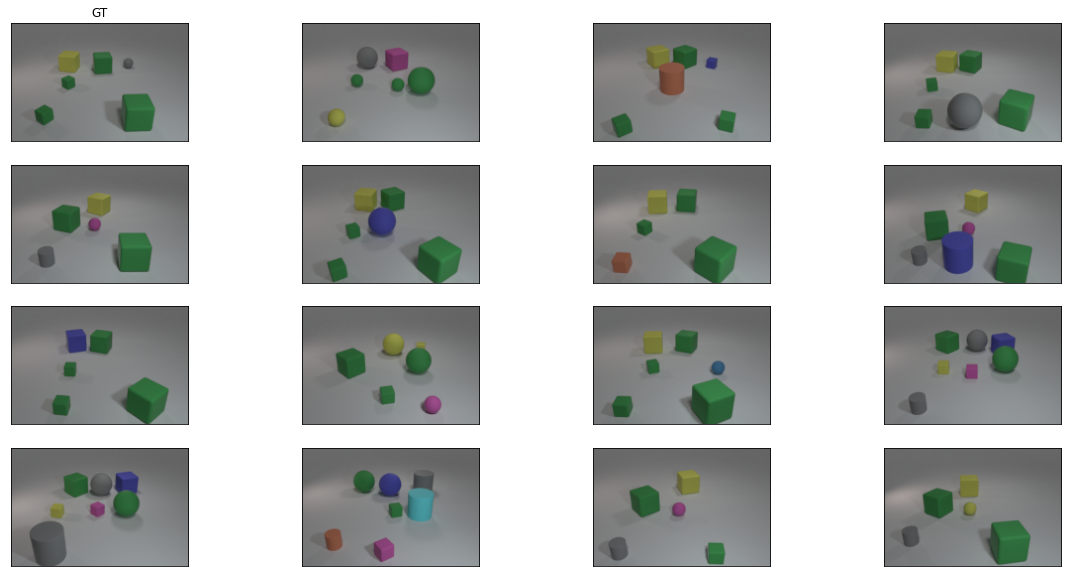

In [50]:
import matplotlib.pyplot as plt

chosen_idx = 5

# Plot query
true_idx = img_ids[chosen_idx]
idx_fill = str(true_idx).zfill(6)
img = cv2.imread(f"../data/CSSDataset/images/css_test_{idx_fill}.png") 
plt.imshow(img)
mod = mods[chosen_idx]
plt.title(mod)

# Plot output
plt.figure(figsize=(20,10))
plt.axis('off')
width = 4
height = 4
for i in range(width*height):
    plt.subplot(width,height,i+1)
    plt.xticks([])
    plt.yticks([])
    idx = str(nn_result[chosen_idx][i])
    idx_fill = idx.zfill(6)
    img = cv2.imread(f"../data/CSSDataset/images/css_test_{idx_fill}.png") 
    plt.imshow(img)
    
    if idx == all_target_captions[chosen_idx]:
        plt.title("GT")

# Reconstruction
To perform reconstruction, one needs:
- Image + text
- Its representation in TIRG


In [ ]:
sample = trainset.generate_random_query_target()
sample

In [ ]:
imgs = torch.unsqueeze(sample['source_img_data'],0).cuda()
texts = sample['mod']['str']
model.compose_img_text(imgs, [texts])